In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
import os
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
os.chdir('/Users/kofiassabil/Downloads/ultimate_challenge')

In [4]:
df_login = pd.read_json('logins.json')
df_login.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
df_login.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [6]:
#aggrate login counts on 15minute intervals
df_login.set_index('login_time', inplace=True)
df_login['count'] = 1
df_login.sort_index(inplace=True)
dfLog_agg = df_login.resample("15min").sum()
dfLog_agg.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


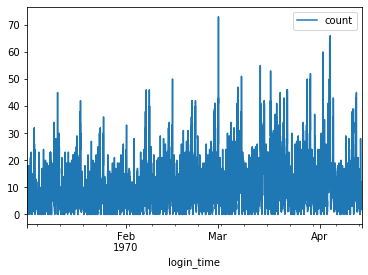

In [7]:
dfLog_agg.plot()
plt.show()

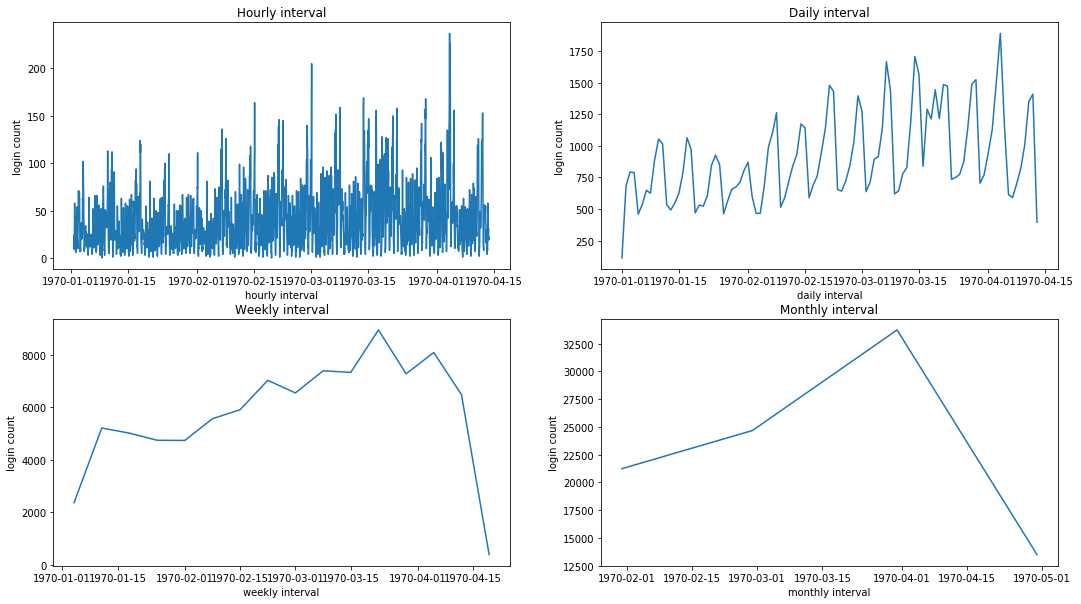

In [8]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18,10));

# 60-min interval
ax1.plot(df_login.resample('60T').sum());
ax1.set(xlabel='hourly interval', ylabel='login count', title='Hourly interval');

# Daily interval
ax2.plot(df_login.resample('D').sum());
ax2.set(xlabel='daily interval', ylabel='login count', title='Daily interval');

# Weekly interval
ax3.plot(df_login.resample('W').sum());
ax3.set(xlabel='weekly interval', ylabel='login count', title='Weekly interval');

# Monthly interval
ax4.plot(df_login.resample('M').sum());
ax4.set(xlabel='monthly interval', ylabel='login count', title='Monthly interval');

What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

- Ultimate Gotham is looks to be most active during night/evening time. Ultimate Metropolis is most active during the day and during the weekends both cities have a good amount of activity. The key metic would be change in weekday activity. Checking during the daytime hours on weekdays you can see there is an increase of cars enering the bridge from Gotham and during the night there is an increase of cars entering the bridge from Metropolis.


Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: a) how you will implement the experiment b) what statistical test(s) you will conduct to verify the significance of the observation c) how you would interpret the results and provide recommendations to the city operations team along with any caveats

- a ztest is an experiment that can be used. Sample size can be 30 drivers. The null hypothesis can be no difference in drivers crossing the bridge. The alternative is there an increase in driver bridge crossings. Calculate the zsocre with an alpha of .05. If p-value is less than .05 we reject the null hypothesis and say there's an increase in driver bridges. I would recommend only considering the policy where it's obivous there's a post-reimbursement increase

In [24]:
df = pd.read_json('ultimate_data_challenge.json')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [25]:
#drop rows with no phone type
df = df.drop(df[df.phone.isna()==True].index,axis=0)

In [39]:
df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean(),inplace=True)
df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean(),inplace=True)

In [40]:
#chang last trip to timestamp type
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [41]:
#set current date 
current_date = df['last_trip_date'].max()
#check if user qualifies as active
df['active'] = df['last_trip_date'].apply(lambda date: 0 if (current_date-date).days>30 else 1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [42]:
# % of drivers who are active after 6 months
cnt = df['active'].value_counts()
cnt/49604*100

0    62.35989
1    37.64011
Name: active, dtype: float64

In [43]:
df_features = pd.get_dummies(df,columns=['city','phone','ultimate_black_user'])
df_features.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,1,0,1,0


In [44]:
target = df_features['active']
df_features = df_features.drop(['last_trip_date','signup_date','active'],axis=1)
df_features.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0


In [49]:
#random forest model
scaler = QuantileTransformer()
scaled_features = scaler.fit_transform(df_features)
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2,random_state=42)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
rf.score(X_test,y_test)

0.7508315693982461

In [50]:
cv_score=cross_val_score(rf,X_test,np.ravel(y_test),cv=5)
print('Mean Cross Validated Score is',np.mean(cv_score))

Mean Cross Validated Score is 0.7481097139839117


In [51]:
df_importance = pd.DataFrame(zip(list(df_features.columns),rf.feature_importances_),index=range(df_features.columns.shape[0]),columns=['feature','importance'])
df_importance.sort_values(by='importance',ascending=False)

,feature,importance
5,avg_dist,0.299866
4,weekday_pct,0.134985
6,avg_rating_by_driver,0.112619
1,avg_rating_of_driver,0.082091
0,trips_in_first_30_days,0.079995
3,surge_pct,0.077988
2,avg_surge,0.066275
8,city_King's Landing,0.047420
11,phone_iPhone,0.019856
10,phone_Android,0.019693


In [52]:
#confusion matrix
confusion_matrix(y_test,y_pred)

array([[4966, 1234],
       [1238, 2483]])

In [53]:
#logistic regression
logit = LogisticRegression(solver='lbfgs')
param_grid = {'C':np.arange(0.5,5.1,0.1)}
grid = GridSearchCV(logit,param_grid,cv=5)
grid.fit(X_train,np.ravel(y_train))

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,
       4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])},
             pre_dispatch='2*n_jobs', refit=True, return_trai

In [54]:
grid.best_estimator_.C

4.699999999999999

In [55]:
#coefficients for log regression
logit_coef = LogisticRegression(C=grid.best_estimator_.C)
logit_coef.fit(X_train,y_train)
df_coef = pd.DataFrame(zip(list(df_features.columns),logit_coef.coef_[0]),index=range(df_features.columns.shape[0]),columns=['feature','coefficient'])
df_coef

,feature,coefficient
0,trips_in_first_30_days,0.113285
1,avg_rating_of_driver,-0.329935
2,avg_surge,2.529198
3,surge_pct,-1.449693
4,weekday_pct,-0.242823
5,avg_dist,0.157502
6,avg_rating_by_driver,-1.344972
7,city_Astapor,-0.770265
8,city_King's Landing,1.115123
9,city_Winterfell,-0.249166


In [56]:
print(np.mean(cross_val_score(grid,X_test,np.ravel(y_test),cv=5)))

0.7420622917851629


Both models perform exactly the same so there's really no difference between the models.

We built a predictive models both with 75% accuracy which is pretty good.

Random forest model gives us the most important features and the logisitc regression shows us the effect of the features by giving us their coefficents.

With the combination of the random forest and logistic regression model the effect of each variable can be explained and it goes hand in hand with how important that variable is.

In conclusion I think incentives should be offered to riders to use the app on the weekends,to take more trips during their first 30 days, tell drivers not to inflate their ratings they give to riders. These things will increase the chances of more active users in the long run which means more revenue 